In [23]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy.stats import kstest
from scipy.stats import chisquare

# Exercise 2
#### Discrete random variables
---


### 1. Geometric distribution 

We have prepared a function that generates 10 000 samples from geometric distribution. We have chosen 3 arbitrary probabilities and generated histograms to show the distributions.

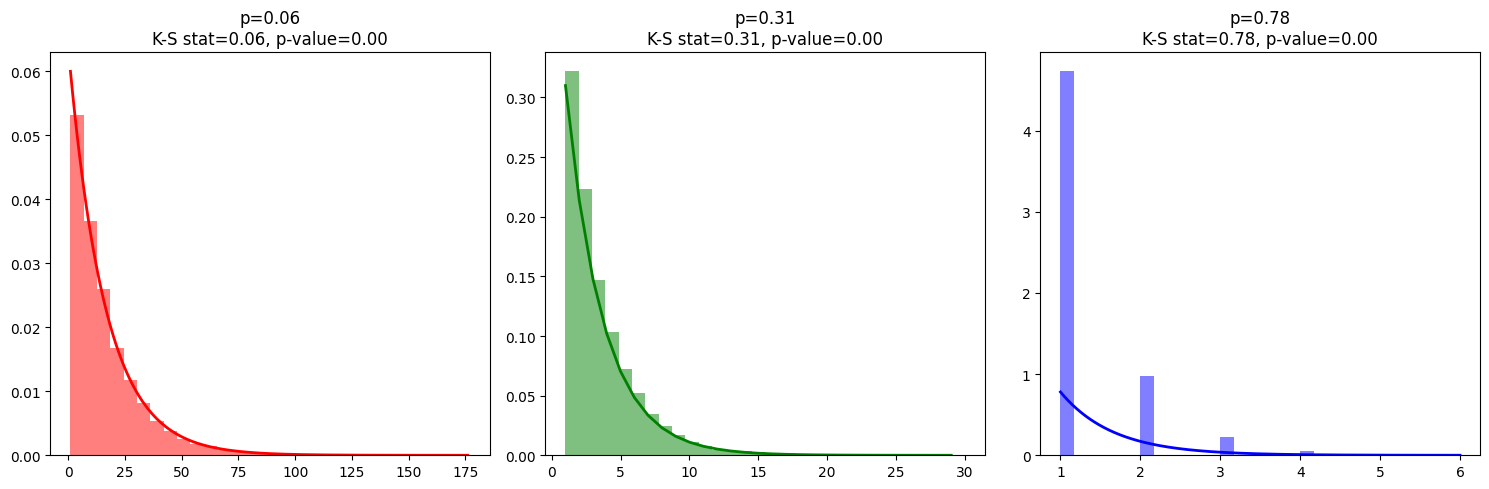

In [24]:
def geom_dist(probability):
    U = np.random.random(10_000)
    return np.floor(np.log(U)/np.log(1-probability)) + 1

def geom_pmf(k, p):
    return p * (1 - p) ** (k - 1)

prob1, prob2, prob3 = 0.06, 0.31, 0.78
result1, result2, result3 = geom_dist(prob1), geom_dist(prob2), geom_dist(prob3)

# Perform K-S test
ks_stat1, p_value1 = kstest(result1, 'geom', args=(prob1,))
ks_stat2, p_value2 = kstest(result2, 'geom', args=(prob2,))
ks_stat3, p_value3 = kstest(result3, 'geom', args=(prob3,))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
count1, bins1, ignored1 = plt.hist(result1, bins=30, density=True, alpha=0.5, color='red')
x1 = np.arange(1, bins1.max())
pmf1 = geom_pmf(x1, prob1)
plt.plot(x1, pmf1, 'r-', linewidth=2)
plt.title(f"p=0.06\nK-S stat={ks_stat1:.2f}, p-value={p_value1:.2f}")

plt.subplot(1, 3, 2)
count2, bins2, ignored2 = plt.hist(result2, bins=30, density=True, alpha=0.5, color='green')
x2 = np.arange(1, bins2.max())
pmf2 = geom_pmf(x2, prob2)
plt.plot(x2, pmf2, 'g-', linewidth=2)
plt.title(f"p=0.31\nK-S stat={ks_stat2:.2f}, p-value={p_value2:.2f}")

plt.subplot(1, 3, 3)
count3, bins3, ignored3 = plt.hist(result3, bins=30, density=True, alpha=0.5, color='blue')
x3 = np.linspace(1, bins3.max(), 1000)
pmf3 = geom_pmf(x3, prob3)
plt.plot(x3, pmf3, 'b-', linewidth=2)
plt.title(f"p=0.78\nK-S stat={ks_stat3:.2f}, p-value={p_value3:.2f}")

plt.tight_layout()
plt.show()



The histogrammes resemble shape of a geometric distribution. Only for the high chance of success the graph is far from ideal, that is probably because it has very little dispertion over X axis. Other than that the lower the probability the better the K-S stat parameter which is the maximum distance between the compared distributions (empirical and analytical). Obviously the smaller the probability of achieving "success", the bigger the number on X-axis which represents the number of tries until "success". I am not sure why the p-values are so low, but they indicate that the empirical distibution does not follow the real geometric distribution.

### 2. The 6 point distribution

There are three techniques we will examine - "the crude method", "the rejection method", and "the alias method", that can be employed to simulate the specified 6-point distribution. Since all those methods relay on at least one random number to pick samples from the 6-point distribution - we will first create two lists of 10 000 random numbers.

In [25]:
num_of_samples = 10_000
np.random.seed(543)
U1 = np.random.uniform(size = num_of_samples)
U2 = np.random.uniform(size = num_of_samples)

#### a) Crude Method

In this method we need to make a Cumulative Distribution Function (CDF) - which is just a cumulative sum of the probabilities, generate one random number and check in which interval of CDF this number lays, then simply take a number assigned to that interval. 

In [26]:
probabilities = np.array([7/48,5/48,1/8,1/16,1/4,5/16])
cdf = np.cumsum(probabilities)

def crude():
    result = np.zeros(num_of_samples)
    for j in range(num_of_samples):
        for i in range(6):
            if U1[j] < cdf[i]:
                result[j] = i+1
                break
    return result

Now let's perform a Chi Squared test for a goodnes of fit of a discrete 6-point distribution.

Chi-squared statistic: 6.84
p-value: 0.23
Fail to reject the null hypothesis: The sample data follows the theoretical distribution.


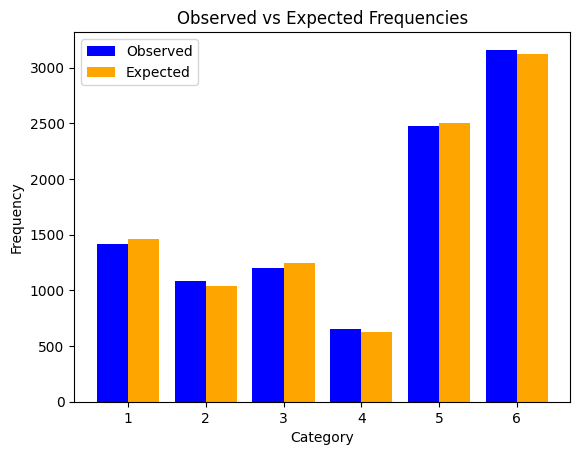

In [27]:
sample_data = crude()

# Calculate observed frequencies
observed_freqs = np.array([np.sum(sample_data == i) for i in range(1, 7)])

# Calculate expected frequencies
expected_freqs = probabilities * num_of_samples

# Perform chi-squared goodness-of-fit test
chi2_stat, p_value = chisquare(f_obs=observed_freqs, f_exp=expected_freqs)

print(f"Chi-squared statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.2f}")

if p_value < 0.05:
    print("Reject the null hypothesis: The sample data does not follow the theoretical distribution.")
else:
    print("Fail to reject the null hypothesis: The sample data follows the theoretical distribution.")

categories = np.arange(1, 7)
plt.bar(categories - 0.2, observed_freqs, width=0.4, label='Observed', color='blue')
plt.bar(categories + 0.2, expected_freqs, width=0.4, label='Expected', color='orange')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Observed vs Expected Frequencies')
plt.legend()
plt.show()


#### b) Rejection Method

In rejection method we use two random numbers. First one to randomly select a nubmer (1-6) from our distribution. Second one to decide if we should accept or reject the chosen number. We make the decision by comparing the second random number with the probability of chosen number scaled to 0-1 range. The nature of rejection method forces us to change the random numbers after rejection occured, therefore we will need to create copies of U1 and U2 so we can change them safely.

In [28]:
k = 6
U1copy = U1.copy()
U2copy = U2.copy()


def rejection():
    result = np.zeros(num_of_samples)
    for i in range(num_of_samples):
        while(result[i]==0):
            I = int(k*U1copy[i]) + 1
            if U2copy[i] <= probabilities[I-1]/max(probabilities):
                result[i] = I
                break
            else:
                U1copy[i], U2copy[i] = np.random.uniform(size=2)
    return result

Now let's perform a Chi Squared test for a goodnes of fit of a discrete 6-point distribution.

Chi-squared statistic (rejection sampling): 7.54
p-value (rejection sampling): 0.18
Fail to reject the null hypothesis: The sample data follows the theoretical distribution.


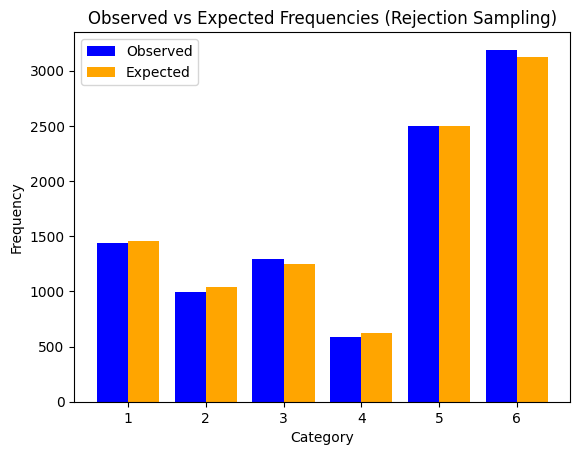

In [29]:
sample_data_rejection = rejection()

observed_freqs_rejection = np.array([np.sum(sample_data_rejection == i) for i in range(1, 7)])
expected_freqs = probabilities * num_of_samples

chi2_stat_rejection, p_value_rejection = chisquare(f_obs=observed_freqs_rejection, f_exp=expected_freqs)

print(f"Chi-squared statistic (rejection sampling): {chi2_stat_rejection:.2f}")
print(f"p-value (rejection sampling): {p_value_rejection:.2f}")

if p_value_rejection < 0.05:
    print("Reject the null hypothesis: The sample data does not follow the theoretical distribution.")
else:
    print("Fail to reject the null hypothesis: The sample data follows the theoretical distribution.")

categories = np.arange(1, 7)
plt.bar(categories - 0.2, observed_freqs_rejection, width=0.4, label='Observed', color='blue')
plt.bar(categories + 0.2, expected_freqs, width=0.4, label='Expected', color='orange')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Observed vs Expected Frequencies (Rejection Sampling)')
plt.legend()
plt.show()

#### c) Alias Method

The alias method is somewhat an improved rejection method, since it works very similarly but after rejection has occured we don't waste the turn and repeat the calculations, instead we just take an alias of the considered number. Alias is just another number that corresponds to the original one. That is why we will need extra alias table that tells us which original number has what alias number.

In [30]:
L = np.arange(0, k)
F = k*probabilities
G = np.nonzero(F>=1)[0]
S = np.nonzero(F<=1)[0]

while len(S)>0:
    i = G[0]
    j = S[0]
    L[j] = i+1
    F[i] = F[i]-(1-F[j])
    
    if F[i]<(1-0.00001):
        G = np.delete(G,0)
        S = np.append(S,i)
    S = np.delete(S,0)

def alias():
    result = np.zeros(num_of_samples)
    for j in range(num_of_samples):
        I = int(np.floor(k*U1[j]) + 1)
        if U2[j] <= F[I-1]:
            result[j] = I
        else:
            result[j] = L[I-1]
    return result

Now let's perform a Chi Squared test for a goodnes of fit of a discrete 6-point distribution.

Chi-squared statistic (alias method): 2.52
p-value (alias method): 0.77
Fail to reject the null hypothesis: The sample data follows the theoretical distribution.


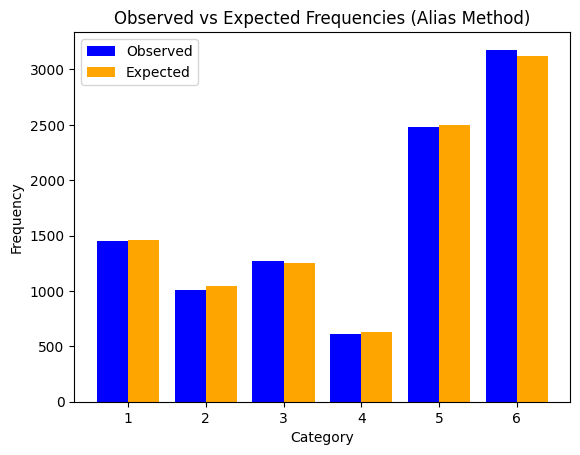

In [31]:
sample_data_alias = alias()

observed_freqs_alias = np.array([np.sum(sample_data_alias == i) for i in range(1, 7)])
expected_freqs = probabilities * num_of_samples

chi2_stat_alias, p_value_alias = chisquare(f_obs=observed_freqs_alias, f_exp=expected_freqs)

print(f"Chi-squared statistic (alias method): {chi2_stat_alias:.2f}")
print(f"p-value (alias method): {p_value_alias:.2f}")

if p_value_alias < 0.05:
    print("Reject the null hypothesis: The sample data does not follow the theoretical distribution.")
else:
    print("Fail to reject the null hypothesis: The sample data follows the theoretical distribution.")

categories = np.arange(1, 7)
plt.bar(categories - 0.2, observed_freqs_alias, width=0.4, label='Observed', color='blue')
plt.bar(categories + 0.2, expected_freqs, width=0.4, label='Expected', color='orange')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Observed vs Expected Frequencies (Alias Method)')
plt.legend()
plt.show()

We can observe that the Chi-squared statistic is lowest for the Aliast method which would suggest it has the best fit with the real distribution. Other than that all the methods have a p-value above 0,05 which means that they follow the theoretical distribution.

### 3. Comparison of the methods

To compare the three abovementioned methods we can take a look at their runtime and most importantly the accuracy of the 6-point distribution mapping.

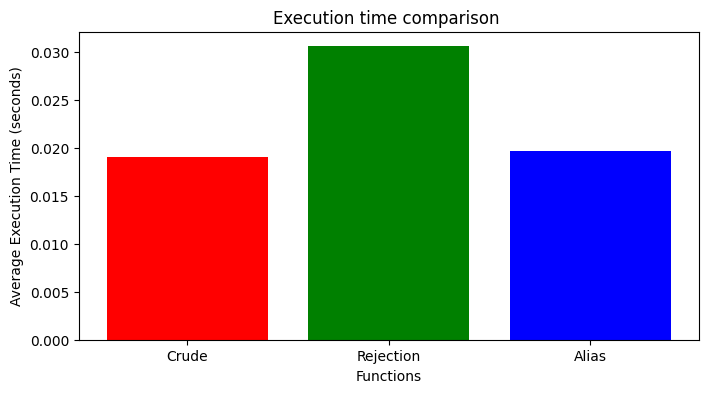

Crude method average time over 100 runs: 0.019011807999922893 seconds
Rejection method average time over 100 runs: 0.030554166999936568 seconds
Alias method average time over 100 runs: 0.019666708000004293 seconds


In [32]:
number_of_runs = 100

crude_time = timeit.timeit(crude, number=number_of_runs) / number_of_runs
rejection_time = timeit.timeit(rejection, number=number_of_runs) / number_of_runs
alias_time = timeit.timeit(alias, number=number_of_runs) / number_of_runs

functions = ['Crude', 'Rejection', 'Alias']
times = [crude_time, rejection_time, alias_time]

plt.figure(figsize=(8, 4))
plt.bar(functions, times, color=['red', 'green', 'blue'])
plt.xlabel('Functions')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Execution time comparison ')
plt.show()

print(f"Crude method average time over {number_of_runs} runs: {crude_time} seconds")
print(f"Rejection method average time over {number_of_runs} runs: {rejection_time} seconds")
print(f"Alias method average time over {number_of_runs} runs: {alias_time} seconds")

While the magnitude of difference may differ depending on the current state of your CPU, the general result is that Crude method is the fastest one, Rejection method is obviously the slowest, because it wastes time rejecting samples, and Aliast method is somewhere in between. 

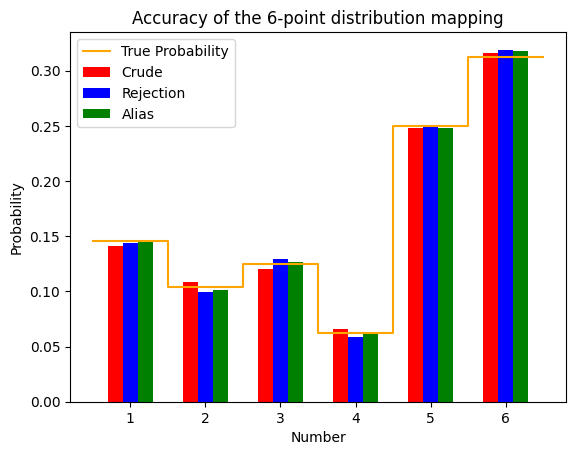

In [33]:
crude_data = crude()
rejection_data = rejection()
alias_data = alias()

bins = np.arange(1, 8) 
bin_centers = np.arange(1, 7)
width = 0.2

hist_data = [np.histogram(data, bins=bins, density=True)[0] for data in [crude_data, rejection_data, alias_data]]

plt.bar(bin_centers - width, hist_data[0], width=width, color='red', label='Crude')
plt.bar(bin_centers, hist_data[1], width=width, color='blue', label='Rejection')
plt.bar(bin_centers + width, hist_data[2], width=width, color='green', label='Alias')
plt.step(np.arange(0.5, 7.5), np.append(probabilities, probabilities[-1]), where="post", color="orange", label="True Probability")

plt.xlabel('Number')
plt.ylabel('Probability')
plt.title('Accuracy of the 6-point distribution mapping')
plt.xticks(bin_centers, labels=[1, 2, 3, 4, 5, 6])
plt.legend()

plt.show()

All the methods seem to be almost equally accurate.

### 4. Recommendations

I would recommend using either Crude or Alias method. Crude method is good when you have very limited computing resources and don't need the highest accuracy. The Alias method has a drawback of complicated initial setup but then it is quite computationaly efficient (not as efficient as Crude though) while also being the most accurate. Rejection method is much slower than other two and provides no substantial accuracy benefit over Crude method. Although it is worth noting that with much higher number of possible results than 1-6 the crude method will be very affected because it need to look for correct interval on CDF. The Alias method would be better option then, because while the initial alias table setup will also take much longer, the generation of numbers will not take much longer.